In [197]:
# potrebne knjiznice
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error

## Uvoz podatkov **SEEDS_TP_A+_A-**

In [198]:
# uvoz podatkov
data_A = pd.read_csv("SEEDS_TP_A+_A-.csv", index_col=0).iloc[1:,:]
data_A = data_A.apply(pd.to_numeric)
data_A.index = pd.to_datetime(data_A.index, format="%d/%m/%Y %H:%M")
data_A.index = pd.date_range(start=data_A.index[0], periods=len(data_A), freq="15T")

# 1 mesec, 2 dni za napoved
df = data_A[(data_A["TP BENCINSKI SERVIS 3 2781_A+_401"].index >= "2023-02-01") &
                (data_A["TP BENCINSKI SERVIS 3 2781_A+_401"].index < "2023-03-03")][["TP BENCINSKI SERVIS 3 2781_A+_401"]]
df["time"] = df.index
df["id"] = 2 # mesec
df.columns = ["moc", "time", "id"]

## Recursive forecast

### tsfresh

$\dots t-4, t-3, t-2, t-1$ za napoved $t+1$

$\dots t-4, t-3, t-2, t-1$ in napovedano $t+1$ za napoved $t+2$

In [27]:
timeshift = 4*24
days = 2

# train/test split
data_train = df[:len(df)-timeshift*days]
data_test = df[-timeshift*days:]

# target split
y_train = data_train.moc.shift(-1)
y_train.dropna(inplace = True)

# features for training data, max and min window sizes are equal -> 4*24 = 1 day 
data_rolled = roll_time_series(data_train, column_id="id", column_sort="time", max_timeshift=timeshift, min_timeshift=timeshift)
features_train = extract_features(data_rolled, column_id="id", column_sort="time", column_value="moc")
features_train.index = features_train.index.map(lambda x: x[1])
features_train_selected = features_train.drop(columns=features_train.columns[features_train.isna().sum() != 0]) # one feature has only NAs

# target in features indeksi
y_train = y_train[y_train.index.isin(features_train_selected.index)]
features_train_selected = features_train_selected[features_train_selected.index.isin(y_train.index)]

# feature selection with tsfresh
features_train_selected = select_features(features_train_selected, y_train)

Feature Extraction: 100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


## Decision Tree Regressor

In [35]:
# fit model na 2023-02-02 00:15:00 to 2023-02-28 23:30:00
model = DecisionTreeRegressor(random_state=42).fit(features_train_selected, y_train)
# prediction za 2023-03-01 00:00:00 with features from 2023-02-28 23:45:00
pred = model.predict(features_train.loc[:,features_train_selected.columns].iloc[-1:,:])

all_pred = []
data_train_forecast = data_train[-timeshift+1:]  # 28.2.2024
for i in range(len(data_test)):
    # za racunanje features za naslednji dan z tsfresh 
    temp = pd.concat([
        pd.DataFrame({"moc":pred[0], "time":data_train_forecast[-1:].index + datetime.timedelta(minutes=15), "id": 2}),
        pd.DataFrame({"moc":pred[0], "time":data_train_forecast[-1:].index + datetime.timedelta(minutes=30), "id": 2})
    ]) # 2023-03-01 ob 0.00h in 0.15h
    temp.index = temp["time"]
    # # dodamo 2023-03-01 ob 0.00h in 0.15h
    data_train_forecast = pd.concat([data_train_forecast, temp])

    # featursi
    data_rolled_forecast = roll_time_series(data_train_forecast, column_id="id", column_sort="time", 
                                            max_timeshift=timeshift, min_timeshift=timeshift, disable_progressbar=True)
    features_test = extract_features(data_rolled_forecast, column_id="id", column_sort="time", 
                                     column_value="moc", n_jobs=0, disable_progressbar=True)

    # Calculate prediction for nex timestep
    pred = model.predict(features_test.loc[:,features_train_selected.columns])
    # save prediction for latter use
    all_pred.append(pred[0])

    # Delete last row in data_train_forecast, because it was only used for tsfresh procedure
    data_train_forecast = data_train_forecast[:len(data_train_forecast)-1]    
    # Delete first row in data_train_forecast, because new prediction will be added for feature calculation
    data_train_forecast = data_train_forecast[1:]

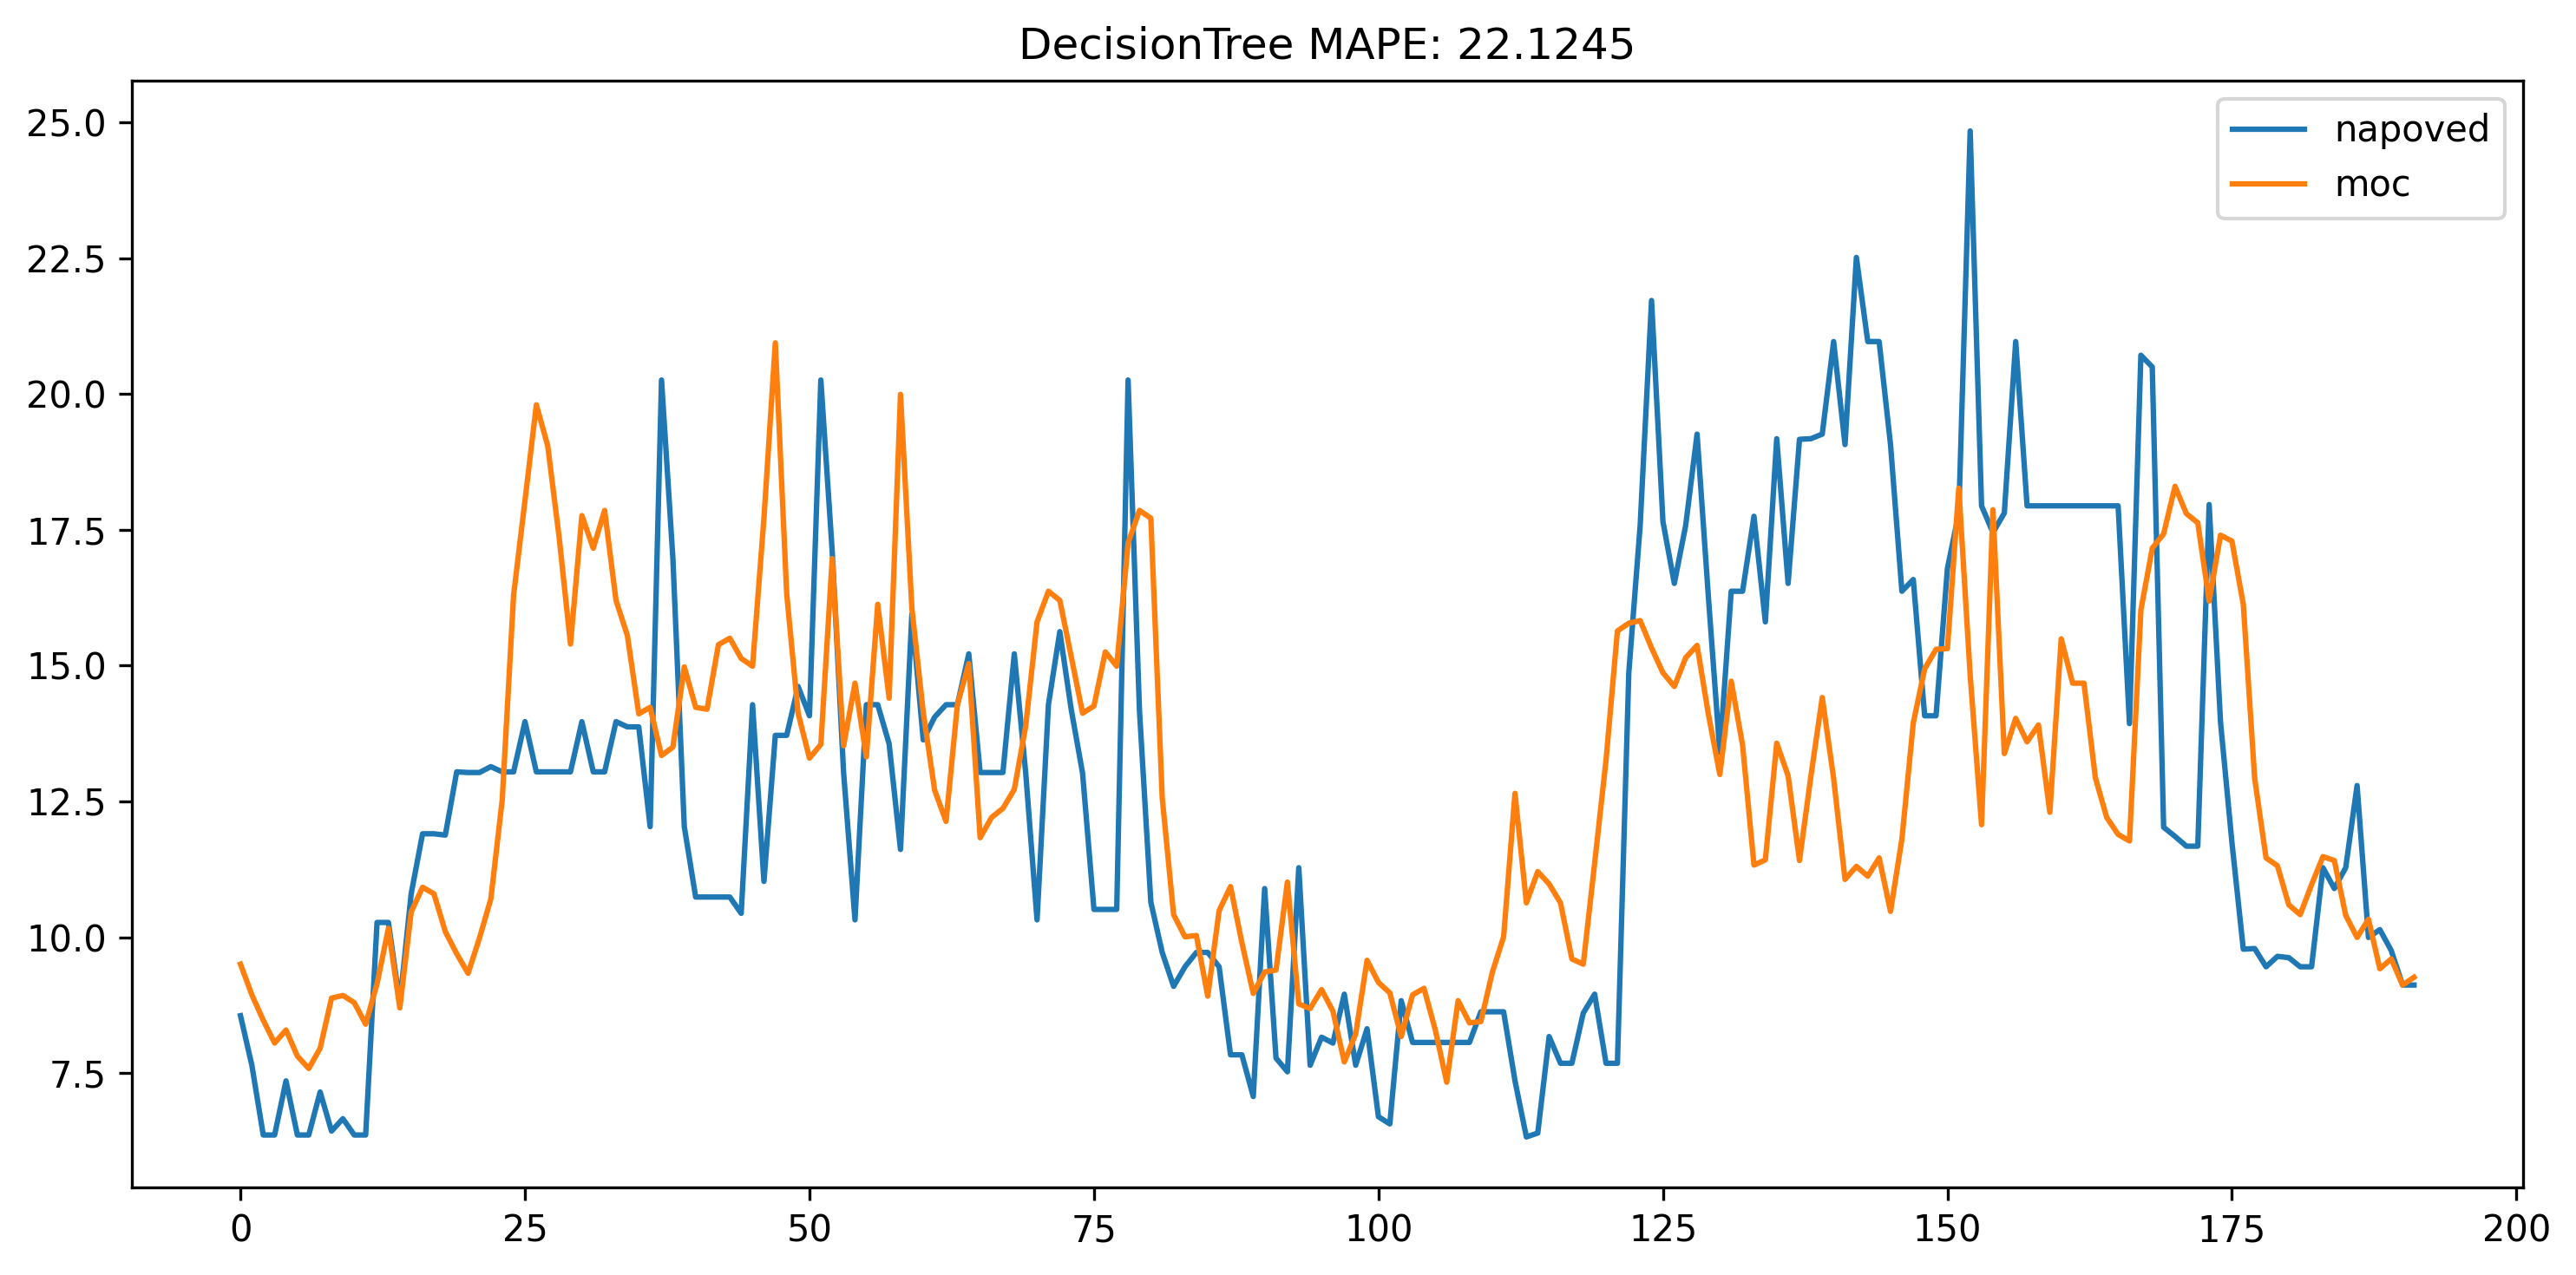

In [37]:
fig = plt.figure(num=None, figsize=(10, 5), dpi=300, tight_layout=True)
plt.plot(all_pred, label = "napoved")
plt.plot(data_test["moc"].values, label = "moc")
plt.title(f"DecisionTree MAPE: {round(mean_absolute_percentage_error(y_pred=all_pred, y_true=data_test['moc'].values), 6)*100}")
plt.legend(loc='upper right')

# Dodam _napetost_ in _tok_

In [199]:
# uvoz podatkov SEEDS_TP_V
data_V = pd.read_csv("SEEDS_TP_V.csv", index_col=0).iloc[1:,:]
data_V = data_V.apply(pd.to_numeric)
data_V.index = pd.to_datetime(data_V.index, format="%d/%m/%Y %H:%M")
data_V.index = pd.date_range(start=data_V.index[0], periods=len(data_V), freq="15T")

df_V = data_V.iloc[:, 6:]
df_V = df_V[(df_V.index >= "2023-02-01") & (df_V.index < "2023-03-03")]

# uvoz podatkov EEDS_I
data_I = pd.read_excel("SEEDS_I.xlsx", index_col=0).iloc[1:,:]
data_I = data_I.apply(pd.to_numeric)
data_I.index = pd.to_datetime(data_I.index, format="%d/%m/%Y %H:%M")
data_I.index = pd.date_range(start=data_I.index[0], periods=len(data_I), freq="15T")

df_I = data_I.iloc[:, 6:]
df_I = df_I[(df_I.index >= "2023-02-01") & (df_I.index < "2023-03-03")]

df = pd.concat([df, df_I, df_V], axis=1)
del df['time'], df['id']
df['id'] = 2
df["time"] = df.index


In [223]:
timeshift = 4*24
days = 2

# train/test split
data_train = df[:len(df)-timeshift*days]
data_test = df[-timeshift*days:]

# target split
y_train = data_train.moc.shift(-1)
y_train.dropna(inplace = True)

# features za training data, max in min window je 4*24 = 1 dan
data_rolled = roll_time_series(data_train, column_id="id", column_sort="time", max_timeshift=timeshift, min_timeshift=timeshift)
features_train = extract_features(data_rolled, column_id="id", column_sort="time")
features_train.index = features_train.index.map(lambda x: x[1])
features_train_selected = features_train.drop(columns=features_train.columns[features_train.isna().sum() != 0]) 

# target in features indeksi
y_train = y_train[y_train.index.isin(features_train_selected.index)]
features_train_selected = features_train_selected[features_train_selected.index.isin(y_train.index)]

# feature selection with tsfresh
features_train_selected = select_features(features_train_selected, y_train)

Feature Extraction: 100%|██████████| 20/20 [04:32<00:00, 13.62s/it]


In [224]:
# fit model na 2023-02-02 00:15:00 to 2023-02-28 23:30:00
model = DecisionTreeRegressor(random_state=42).fit(features_train_selected, y_train)
# prediction za 2023-03-01 00:00:00 with features from 2023-02-28 23:45:00
pred = model.predict(features_train.loc[:,features_train_selected.columns].iloc[-1:,:])

all_pred = []
data_train_forecast = data_train[-timeshift+1:]  # 28.2.2024
for i in range(len(data_test)):
    # za racunanje features za naslednji dan z tsfresh 
    temp = pd.concat([
        pd.DataFrame({"moc":pred[0], "time":data_train_forecast[-1:].index + datetime.timedelta(minutes=15), "id": 2, 
                      "TP BENCINSKI SERVIS 3 2781_I_L1_601":data_train_forecast.iloc[-1:, 1],
                      "TP BENCINSKI SERVIS 3 2781_I_L2_701":data_train_forecast.iloc[-1:, 2],
                      "TP BENCINSKI SERVIS 3 2781_I_L3_801":data_train_forecast.iloc[-1:, 3],
                      "TP BENCINSKI SERVIS 3 2781_V_L1_601":data_train_forecast.iloc[-1:, 4],
                      "TP BENCINSKI SERVIS 3 2781_V_L2_701":data_train_forecast.iloc[-1:, 5],
                      "TP BENCINSKI SERVIS 3 2781_V_L3_801":data_train_forecast.iloc[-1:, 6]}),
        pd.DataFrame({"moc":pred[0], "time":data_train_forecast[-1:].index + datetime.timedelta(minutes=30), "id": 2, 
                      "TP BENCINSKI SERVIS 3 2781_I_L1_601":data_train_forecast.iloc[-1:, 1],
                      "TP BENCINSKI SERVIS 3 2781_I_L2_701":data_train_forecast.iloc[-1:, 2],
                      "TP BENCINSKI SERVIS 3 2781_I_L3_801":data_train_forecast.iloc[-1:, 3],
                      "TP BENCINSKI SERVIS 3 2781_V_L1_601":data_train_forecast.iloc[-1:, 4],
                      "TP BENCINSKI SERVIS 3 2781_V_L2_701":data_train_forecast.iloc[-1:, 5],
                      "TP BENCINSKI SERVIS 3 2781_V_L3_801":data_train_forecast.iloc[-1:, 6]})
    ]) # 2023-03-01 ob 0.00h in 0.15h
    temp.index = temp["time"]
    # # dodamo 2023-03-01 ob 0.00h in 0.15h
    data_train_forecast = pd.concat([data_train, temp])

    # featursi
    data_rolled_forecast = roll_time_series(data_train_forecast, column_id="id", column_sort="time", 
                                            max_timeshift=timeshift, min_timeshift=timeshift, disable_progressbar=True)
    features_test = extract_features(data_rolled_forecast, column_id="id", column_sort="time", n_jobs=0, disable_progressbar=True)

    # Calculate prediction for nex timestep
    pred = model.predict(features_test.loc[:,features_train_selected.columns])
    # save prediction for latter use
    all_pred.append(pred[0])

    # Delete last row in data_train_forecast, because it was only used for tsfresh procedure
    data_train_forecast = data_train_forecast[:len(data_train_forecast)-1]    
    # Delete first row in data_train_forecast, because new prediction will be added for feature calculation
    data_train_forecast = data_train_forecast[1:]

/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


In [211]:
features_train_selected.columns

Index(['moc__index_mass_quantile__q_0.9',
       'moc__fft_coefficient__attr_"real"__coeff_1',
       'moc__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)',
       'moc__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'moc__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)',
       'moc__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)',
       'moc__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)',
       'moc__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
       'moc__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)',
       'moc__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)',
       ...
       'moc__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)',
       'moc__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
       'moc__longest_strike_above_mean',
       'moc__fft_coefficient__attr_"angle"__coeff_15',
       'moc__fft_coefficient__attr_"imag"__coeff_24',
       'moc__change_quantiles__f_agg_"va

In [212]:
features_test.columns

Index(['moc__variance_larger_than_standard_deviation',
       'moc__has_duplicate_max', 'moc__has_duplicate_min',
       'moc__has_duplicate', 'moc__sum_values', 'moc__abs_energy',
       'moc__mean_abs_change', 'moc__mean_change',
       'moc__mean_second_derivative_central', 'moc__median',
       ...
       'moc__fourier_entropy__bins_5', 'moc__fourier_entropy__bins_10',
       'moc__fourier_entropy__bins_100',
       'moc__permutation_entropy__dimension_3__tau_1',
       'moc__permutation_entropy__dimension_4__tau_1',
       'moc__permutation_entropy__dimension_5__tau_1',
       'moc__permutation_entropy__dimension_6__tau_1',
       'moc__permutation_entropy__dimension_7__tau_1',
       'moc__query_similarity_count__query_None__threshold_0.0',
       'moc__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

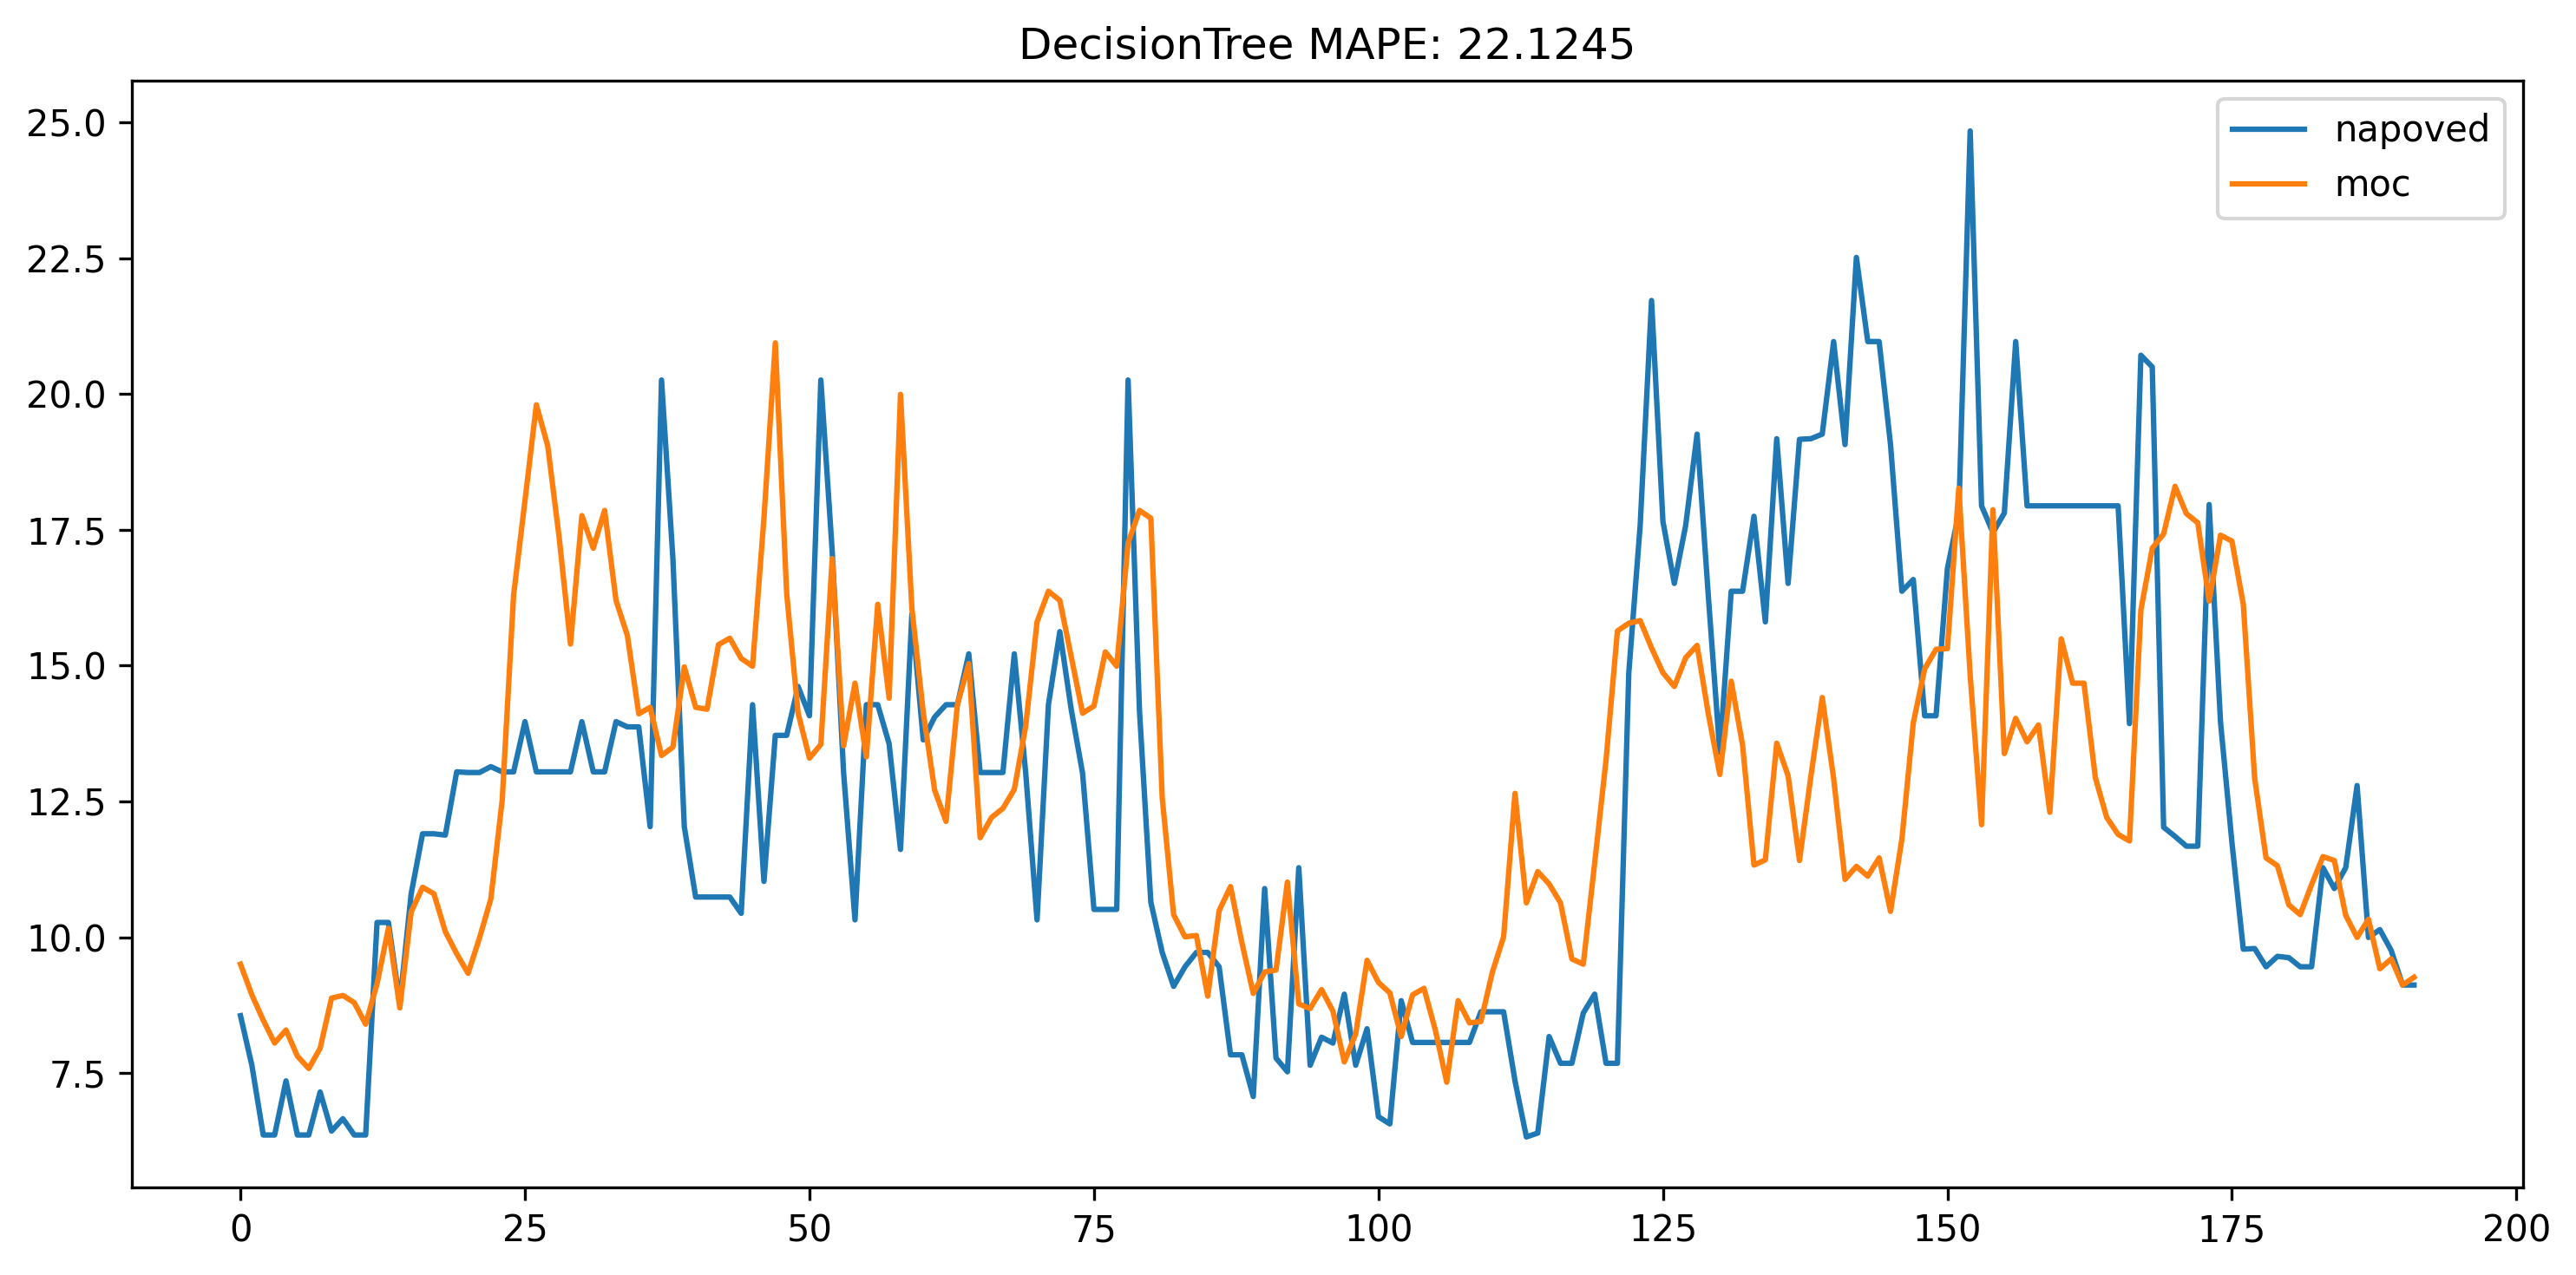

In [205]:
fig = plt.figure(num=None, figsize=(10, 5), dpi=300, tight_layout=True)
plt.plot(all_pred, label = "napoved")
plt.plot(data_test["moc"].values, label = "moc")
plt.title(f"DecisionTree MAPE: {round(mean_absolute_percentage_error(y_pred=all_pred, y_true=data_test['moc'].values), 6)*100}")
plt.legend(loc='upper right')